Implement and compare all (four) models (by average queue size, total working etc.)
Draw server's dynamic through the time (for dynamic queues)

Num of servers: 4 (4 or 5 for dynamic case)
Probability to wait for customers: ~50% (fit feasible parameters)
Random arrival & Random Service (the same for all servers)


In [129]:
##############
## imports ##
##############
import simpy
import numpy as np
import matplotlib.pyplot as plt

In [130]:
# Constants
NUMBER_SERVERS = 4  # For our general queue
SERVICE_TIME = 2  # Average service time
ARRIVAL_INTERVAL = 5  # Create a customer roughly every x seconds
SIM_TIME = 1000  # Simulation time in minutes
RANDOM_SEED = 44

In [131]:
class Customer:
    def __init__(self, name, env):
        self.name = name
        self.arrival_time = env.now
        self.waiting_time = None

In [132]:
class ShortestQueueServer:
    def __init__(self, env, service_time):
        self.env = env
        self.server = simpy.Resource(env, capacity=1)  # each server only serves 1 customer at a time
        self.service_time = service_time
        self.customers = []
        self.queue_size = []
        self.server_status = []

    def serve(self, customer):
        with self.server.request() as req:
            yield req
            customer.waiting_time = self.env.now - customer.arrival_time
            yield self.env.timeout(np.random.exponential(1.0 / self.service_time))
            self.customers.append(customer)

    def update_stats(self):
        while True:
            self.queue_size.append(len(self.server.queue))
            self.server_status.append(self.server.count > 0)  # 0 if idle, 1 if busy
            yield self.env.timeout(1)

In [133]:
class ShortestQueueServerBank:
    def __init__(self, env, num_servers, service_time):
        self.env = env
        self.servers = [ShortestQueueServer(env, service_time) for _ in range(num_servers)]
        self.total_customers = []

    def enter(self, customer):
        # find the server with the shortest queue
        shortest_queue = min(self.servers, key=lambda s: len(s.server.queue))
        self.env.process(shortest_queue.serve(customer))
        self.total_customers.append(customer)

In [134]:
class SimulateShortestQueue:
    def __init__(self, num_servers, service_time, arrival_interval, sim_time):
        self.num_servers = num_servers
        self.service_time = service_time
        self.arrival_interval = arrival_interval
        self.sim_time = sim_time

    def customer_generator(self, env, bank):
        i = 0
        while True:
            i += 1
            yield env.timeout(np.random.exponential(1.0 / self.arrival_interval))
            customer = Customer(f'Customer {i}', env)
            bank.enter(customer)

    def run(self):
        env = simpy.Environment()
        bank = ShortestQueueServerBank(env, self.num_servers, self.service_time)
        env.process(self.customer_generator(env, bank))
        for server in bank.servers:
            env.process(server.update_stats())
        env.run(until=self.sim_time)
        return bank

    def collect_statistics(self, bank):
        total_waiting_times = [c.waiting_time for c in bank.total_customers if c.waiting_time is not None]
        total_server_utilization = sum((c.waiting_time + np.random.exponential(1.0 / self.service_time)) for c in bank.total_customers if c.waiting_time is not None) / self.sim_time
        server_queue_sizes = [server.queue_size for server in bank.servers]
        server_statuses = [server.server_status for server in bank.servers]
        return total_waiting_times, total_server_utilization, server_queue_sizes, server_statuses


    def plot_statistics(self, total_waiting_times, total_server_utilization, server_queue_sizes, server_statuses):
        plt.figure(figsize=(10, 6))
        plt.hist(total_waiting_times, bins=20, alpha=0.5)
        plt.title('Histogram of Waiting Times')
        plt.xlabel('Waiting Time')
        plt.ylabel('Frequency')
        plt.show()

        for i in range(NUMBER_SERVERS):
            plt.figure(figsize=(10, 6))
            plt.plot(server_queue_sizes[i])
            plt.title(f'Server {i+1} Queue Size Over Time')
            plt.xlabel('Time')
            plt.ylabel('Queue Size')
            plt.show()

General queue policy

In [135]:
class GeneralQueueBank:
    def __init__(self, env, num_servers, service_time):
        self.env = env # Simpy environment
        self.server = simpy.Resource(env, num_servers) # Bank servers
        self.customers = [] # List to hold customers
        self.service_time = service_time # Service time for a customer
        self.queue_size = [] # List to hold queue size at each step
        self.server_status = [[] for _ in range(num_servers)]  # Dynamically allocate server status

    def serve(self, customer):
        with self.server.request() as req: # Customer requests a server
            yield req
            # Calculate waiting time
            customer.waiting_time = self.env.now - customer.arrival_time
            # Simulate service time
            yield self.env.timeout(np.random.exponential(1.0 / self.service_time))
            self.customers.append(customer)
    
    # Update statistics
    def update_stats(self):
        while True:
            self.queue_size.append(len(self.server.queue))
            for i in range(NUMBER_SERVERS):  # Updated to number of servers
                # Update each server's status
                self.server_status[i].append(self.server.count > i)
            yield self.env.timeout(1)

In [136]:
class GeneralQueueSimulation:
    def __init__(self, num_servers, service_time, arrival_interval, sim_time):
        self.num_servers = num_servers
        self.service_time = service_time
        self.arrival_interval = arrival_interval
        self.sim_time = sim_time

    # Customer generator
    def customer_generator(self, env, bank):
        i = 0
        while True:
            i += 1
            yield env.timeout(np.random.exponential(1.0 / self.arrival_interval))
            customer = Customer(f'Customer {i}', env)
            env.process(bank.serve(customer))

    # Run the simulation
    def run(self):
        env = simpy.Environment()
        bank = GeneralQueueBank(env, self.num_servers, self.service_time)
        env.process(self.customer_generator(env, bank))
        env.process(bank.update_stats())
        env.run(until=self.sim_time)
        return bank

    # Collect statistics
    def collect_statistics(self, bank):
        waiting_times = [c.waiting_time for c in bank.customers]
        # Calculate server utilization
        server_utilization = sum(c.waiting_time + np.random.exponential(1.0 / self.service_time) for c in bank.customers) / self.sim_time
        return waiting_times, server_utilization, bank.queue_size, bank.server_status

    # Plot statistics
    def plot_statistics(self, waiting_times, server_utilization, queue_size, server_status):
        # Waiting times
        plt.figure(figsize=(10, 6))
        plt.hist(waiting_times, bins=20, alpha=0.5)
        plt.title('Histogram of Waiting Times')
        plt.xlabel('Waiting Time')
        plt.ylabel('Frequency')
        plt.show()

        # Queue size
        plt.figure(figsize=(10, 6))
        plt.plot(queue_size)
        plt.title('Queue Size Over Time')
        plt.xlabel('Time')
        plt.ylabel('Queue Size')
        plt.show()

        # # Server utilization
        # plt.figure(figsize=(10, 6))
        # plt.bar(['Server Utilization', 'Idle Time'], [server_utilization, 1 - server_utilization])
        # plt.title('Server Utilization')
        # plt.ylabel('Proportion')
        # plt.ylim(0, 1)
        # plt.show()

        # Server status over time
        for i in range(NUMBER_SERVERS):  # Updated to number of servers
            plt.figure(figsize=(10, 6))
            plt.plot(server_status[i])
            plt.title(f'Server {i+1} Status Over Time')
            plt.xlabel('Time')
            plt.ylabel('Server Status (Busy=True)')
            plt.show()

Dynamic Shortest Queue

In [137]:
class DynamicShortestCustomer:
    def __init__(self, name, arrival_time):
        self.name = name
        self.arrival_time = arrival_time
        self.service_start_time = None
        self.waiting_time = None


class DynamicShortestQueueServer:
    def __init__(self, env, service_time):
        self.env = env
        self.service_time = service_time
        self.server = simpy.Resource(env, capacity=1)
        self.queue_size = [0]
        self.server_status = []

    def serve(self, customer):
        with self.server.request() as request:
            yield request

            customer.service_start_time = self.env.now
            customer.waiting_time = customer.service_start_time - customer.arrival_time

            yield self.env.timeout(np.random.exponential(self.service_time))

    def update_stats(self):
        while True:
            self.queue_size.append(len(self.server.queue))
            self.server_status.append(self.server.count)
            yield self.env.timeout(1)  # Update stats every minute


class DynamicShortestQueueBank:
    def __init__(self, env, num_servers, service_time):
        self.env = env
        self.service_time = service_time
        self.servers = [DynamicShortestQueueServer(env, service_time) for _ in range(num_servers)]
        self.total_customers = []

    def enter(self, customer):
        shortest_queue = min(self.servers, key=lambda s: len(s.server.queue))
        self.env.process(shortest_queue.serve(customer))
        self.total_customers.append(customer)

    def monitor(self, min_servers, max_servers):
        while True:
            busy_servers = [server for server in self.servers if server.server.count > 0]
            free_servers = [server for server in self.servers if server.server.count == 0]

            if len(busy_servers) == len(self.servers) and len(self.servers) < max_servers:
                # All servers are busy, add a server
                new_server = DynamicShortestQueueServer(self.env, self.service_time)
                self.servers.append(new_server)
                self.env.process(new_server.update_stats())

            elif len(free_servers) >= 2 and len(self.servers) > min_servers:
                # Two or more servers are free, remove a server
                server_to_remove = free_servers[0]
                self.servers.remove(server_to_remove)

            yield self.env.timeout(1)  # Check every minute


class DynamicShortestQueueSimulation:
    def __init__(self, num_servers, service_time, arrival_interval, sim_time):
        self.num_servers = num_servers
        self.service_time = service_time
        self.arrival_interval = arrival_interval
        self.sim_time = sim_time

    def customer_generator(self, env, bank):
        for i in range(int(self.sim_time / self.arrival_interval)):
            yield env.timeout(np.random.exponential(self.arrival_interval))
            customer = DynamicShortestCustomer(f'Customer {i}', env.now)
            bank.enter(customer)

    def run(self):
        env = simpy.Environment()
        bank = DynamicShortestQueueBank(env, self.num_servers, self.service_time)
        env.process(self.customer_generator(env, bank))
        env.process(bank.monitor(min_servers=self.num_servers, max_servers=2*self.num_servers))  # Start the monitor process
        for server in bank.servers:
            env.process(server.update_stats())
        env.run(until=self.sim_time)
        return bank

    def collect_statistics(self, bank):
        total_waiting_times = [c.waiting_time for c in bank.total_customers]
        total_server_utilization = sum(c.waiting_time + np.random.exponential(1.0 / self.service_time) for c in bank.total_customers) / self.sim_time
        server_queue_sizes = [server.queue_size for server in bank.servers]
        server_statuses = [server.server_status for server in bank.servers]

        return total_waiting_times, total_server_utilization, server_queue_sizes, server_statuses

    def plot_statistics(self, total_waiting_times, total_server_utilization, server_queue_sizes, server_statuses):
        # Histogram of waiting times
        plt.figure(figsize=(12, 8))
        plt.hist(total_waiting_times, bins=20, density=True)
        plt.xlabel('Waiting time')
        plt.ylabel('Frequency')
        plt.title('Histogram of waiting times')
        plt.grid(True)
        plt.show()

        # Total server utilization
        print(f'Total server utilization: {total_server_utilization}')

        # Queue size over time
        for i, queue_size in enumerate(server_queue_sizes):
            plt.plot(queue_size, label=f'Server {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Queue size')
        plt.title('Queue size over time')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Server status over time
        for i, server_status in enumerate(server_statuses):
            plt.plot(server_status, label=f'Server {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Server status (0=free, 1=busy)')
        plt.title('Server status over time')
        plt.legend()
        plt.grid(True)
        plt.show()



Dynamic General Queue

In [138]:
# Customer class to represent customers arriving at the bank
class DynamicGeneralQueueCustomer:
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.waiting_time = None

# Server class to represent the bank's servers (tellers)
class DynamicGeneralQueueServer:
    def __init__(self, env, service_time):
        self.env = env
        self.server = simpy.Resource(env, capacity=1)
        self.service_time = service_time
        self.queue_size = []
        self.server_status = []

    def serve(self, customer):
        with self.server.request() as request:
            yield request

            customer.waiting_time = self.env.now - customer.arrival_time
            service_time = np.random.exponential(self.service_time)
            yield self.env.timeout(service_time)

    def update_stats(self):
        while True:
            self.queue_size.append(len(self.server.queue))
            self.server_status.append(self.server.count)
            yield self.env.timeout(1)  # update every minute

# Bank class to handle customer arrivals and interaction with servers
class DynamicGeneralQueueBank:
    def __init__(self, env, num_servers, service_time):
        self.env = env
        self.service_time = service_time
        self.servers = [DynamicGeneralQueueServer(env, service_time) for _ in range(num_servers)]
        self.total_customers = []

    def enter(self, customer):
        shortest_queue = min(self.servers, key=lambda s: len(s.server.queue))
        self.env.process(shortest_queue.serve(customer))
        self.total_customers.append(customer)

    def monitor(self, min_servers, max_servers):
        while True:
            busy_servers = [server for server in self.servers if server.server.count > 0]
            free_servers = [server for server in self.servers if server.server.count == 0]

            if len(busy_servers) == len(self.servers) and len(self.servers) < max_servers:
                # All servers are busy, add a server
                new_server = DynamicGeneralQueueServer(self.env, self.service_time)
                self.servers.append(new_server)
                self.env.process(new_server.update_stats())

            elif len(free_servers) >= 2 and len(self.servers) > min_servers:
                # Two or more servers are free, remove a server
                server_to_remove = free_servers[0]
                self.servers.remove(server_to_remove)

            yield self.env.timeout(1)  # Check every minute


# Simulation class to run the simulation and collect statistics
class DynamicGeneralQueueSimulation:
    def __init__(self, num_servers, service_time, arrival_interval, sim_time):
        self.num_servers = num_servers
        self.service_time = service_time
        self.arrival_interval = arrival_interval
        self.sim_time = sim_time

    def customer_generator(self, env, bank):
        while True:
            yield env.timeout(np.random.exponential(self.arrival_interval))
            bank.enter(DynamicGeneralQueueCustomer(env.now))

    def run(self):
        env = simpy.Environment()
        bank = DynamicGeneralQueueBank(env, self.num_servers, self.service_time)
        env.process(self.customer_generator(env, bank))
        env.process(bank.monitor(min_servers=self.num_servers, max_servers=2*self.num_servers))  # Start the monitor process
        for server in bank.servers:
            env.process(server.update_stats())
        env.run(until=self.sim_time)
        return bank

    def collect_statistics(self, bank):
        total_waiting_times = [c.waiting_time for c in bank.total_customers if c.waiting_time is not None]
        total_server_utilization = sum((c.waiting_time + np.random.exponential(1.0 / self.service_time)) for c in bank.total_customers if c.waiting_time is not None) / self.sim_time
        server_queue_sizes = [server.queue_size for server in bank.servers]
        server_statuses = [server.server_status for server in bank.servers]
        return total_waiting_times, total_server_utilization, server_queue_sizes, server_statuses

    def plot_statistics(self, total_waiting_times, total_server_utilization, server_queue_sizes, server_statuses):
        plt.figure(figsize=(10, 6))
        plt.hist(total_waiting_times, bins=20, alpha=0.5)
        plt.title('Histogram of Waiting Times')
        plt.xlabel('Waiting Time')
        plt.ylabel('Frequency')
        plt.show()

        # plt.figure(figsize=(10, 6))
        # plt.bar(['Server Utilization', 'Idle Time'], [total_server_utilization, 1 - total_server_utilization])
        # plt.title('Server Utilization')
        # plt.ylabel('Proportion')
        # plt.ylim(0, 1)
        # plt.show()

        for i in range(len(server_queue_sizes)):
            plt.figure(figsize=(10, 6))
            plt.plot(server_queue_sizes[i])
            plt.title(f'Server {i+1} Queue Size Over Time')
            plt.xlabel('Time')
            plt.ylabel('Queue Size')
            plt.show()

General Queue Stats


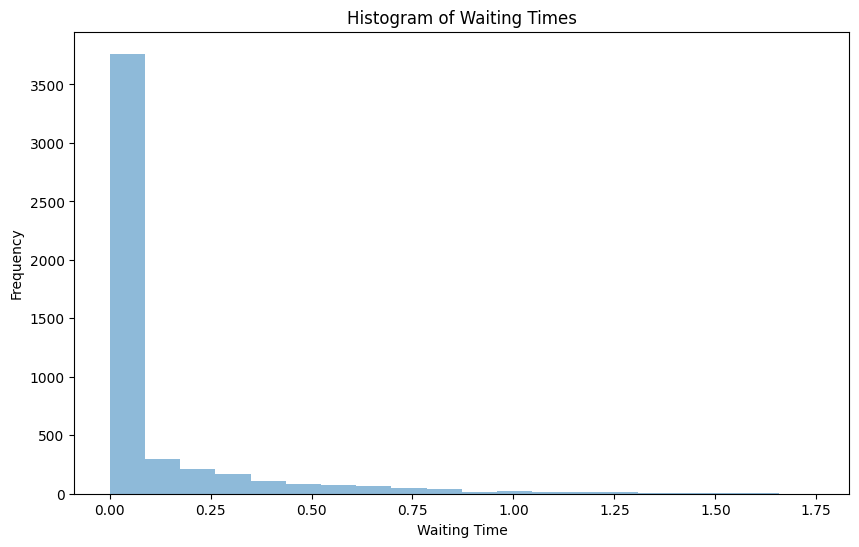

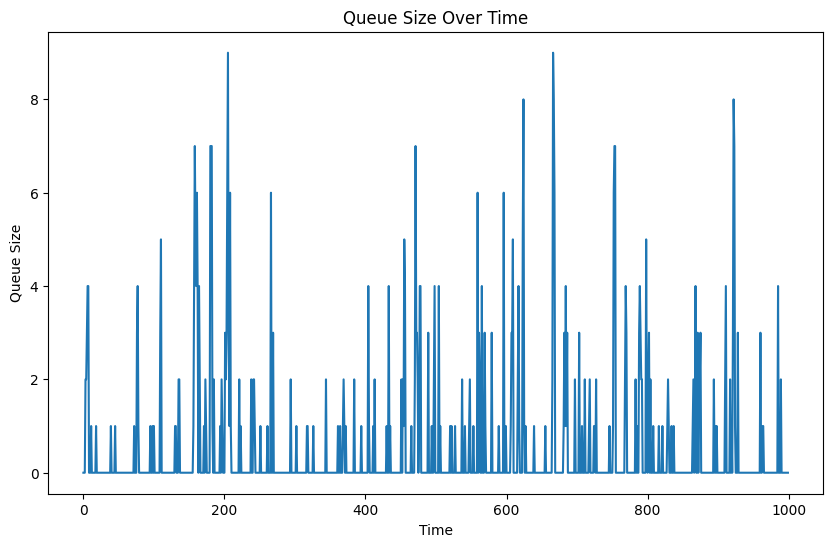

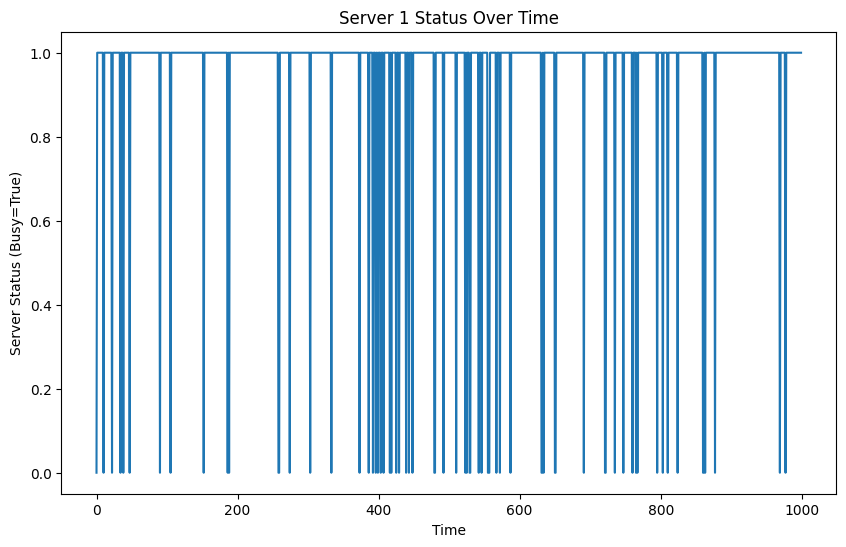

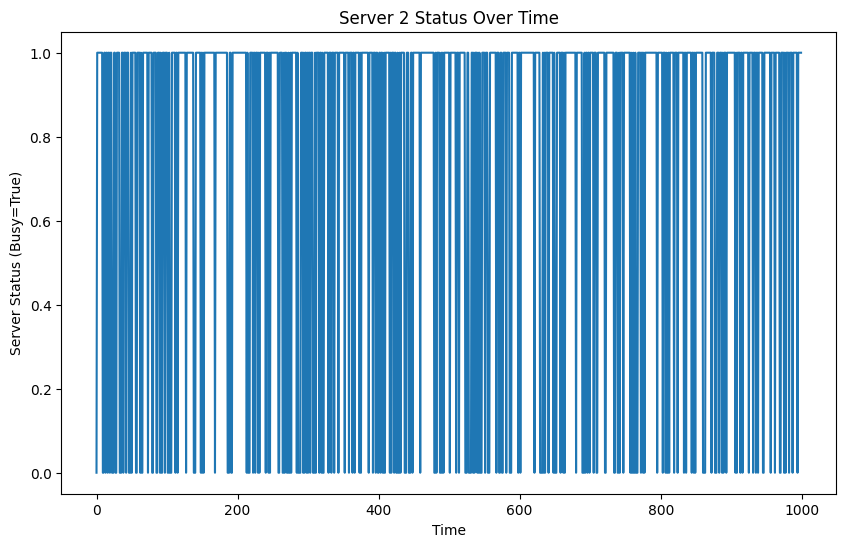

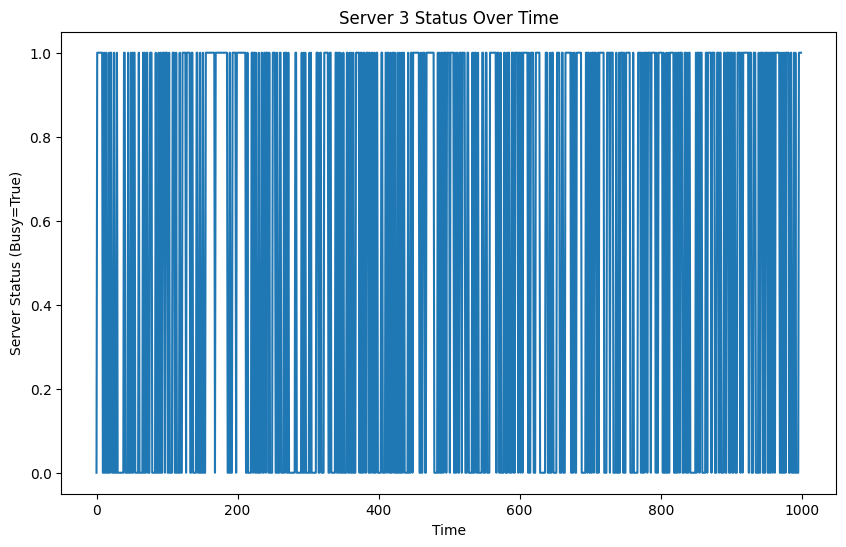

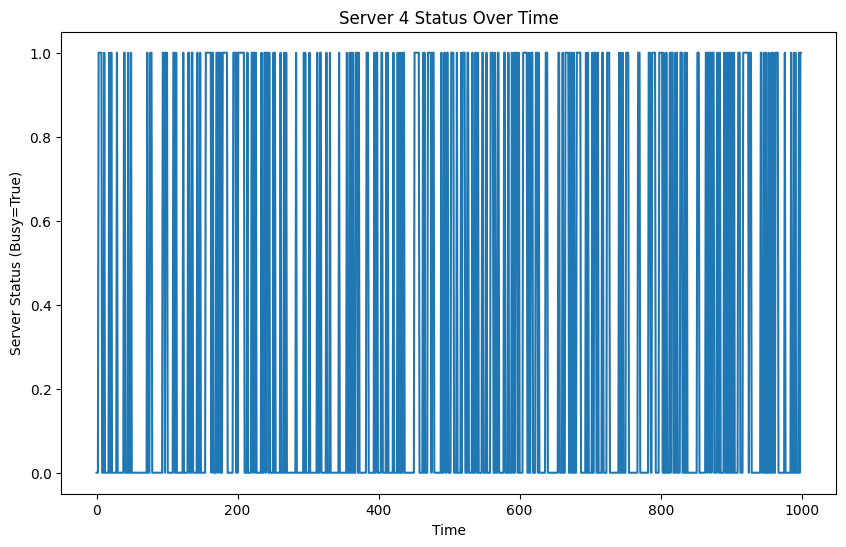

Shortest Queue Stats


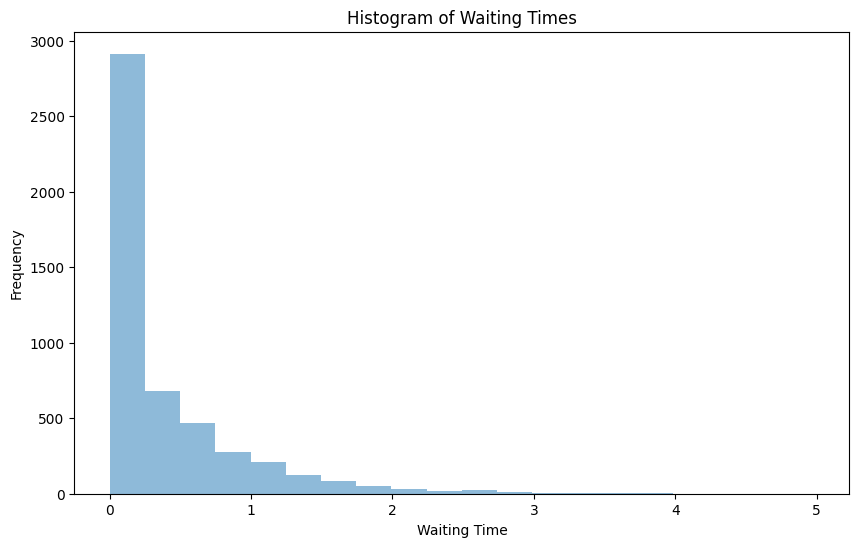

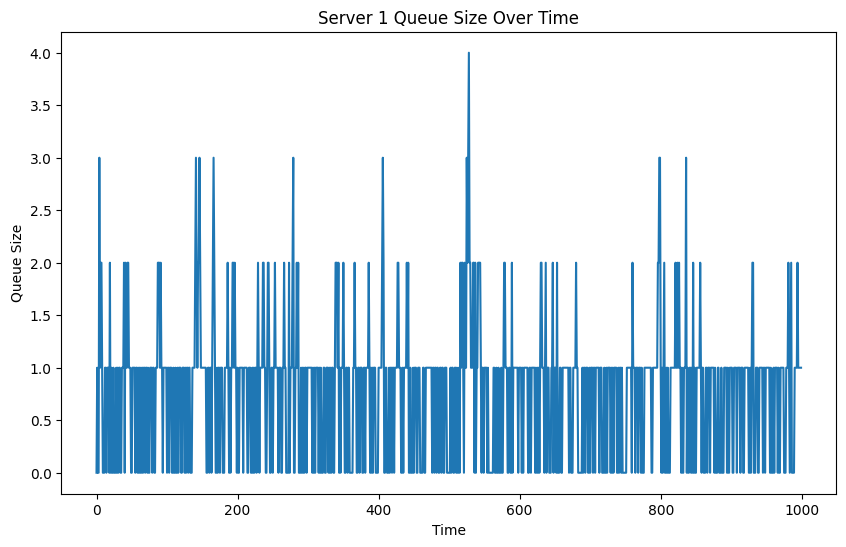

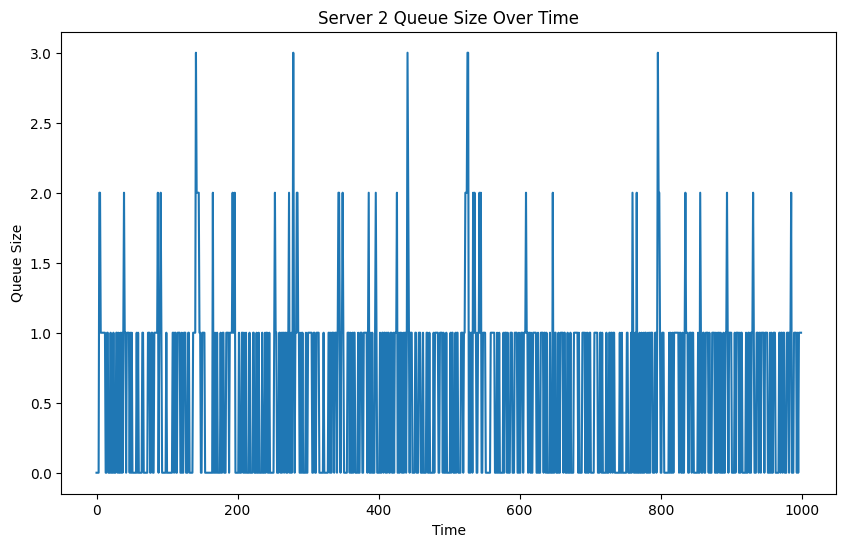

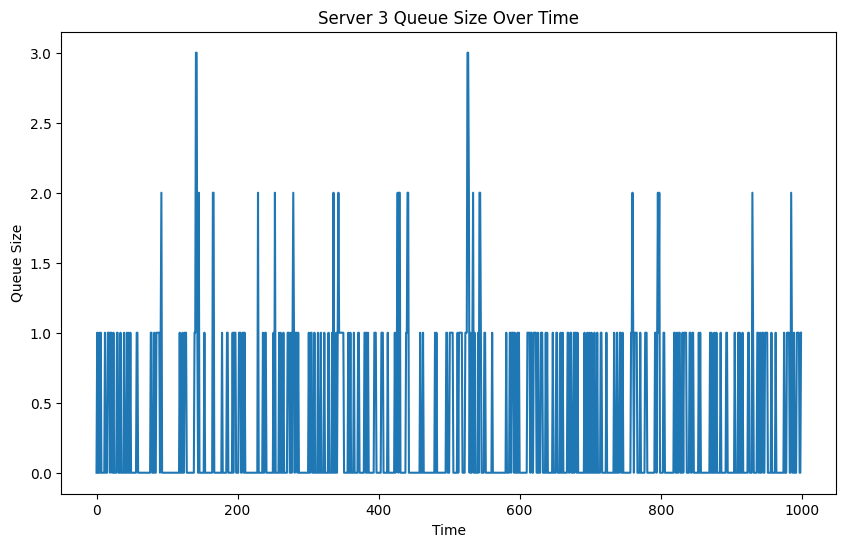

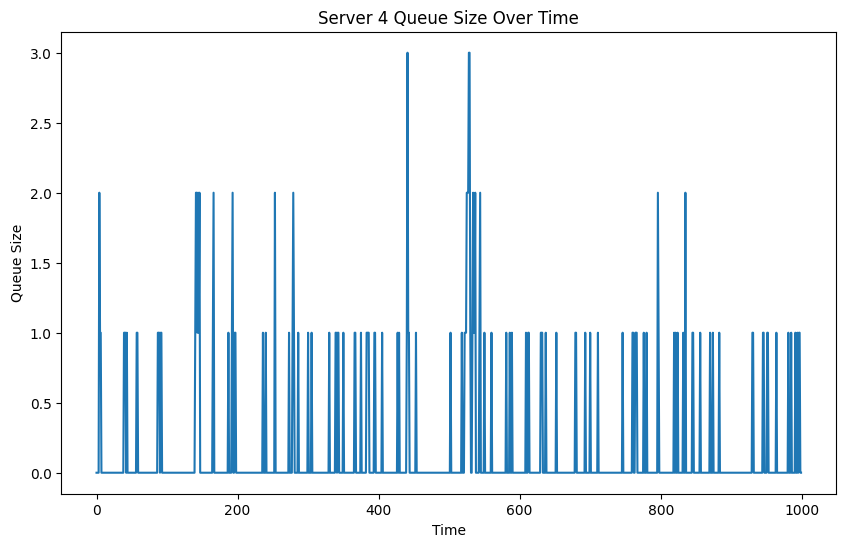

Dynamic Shortest Queue Stats


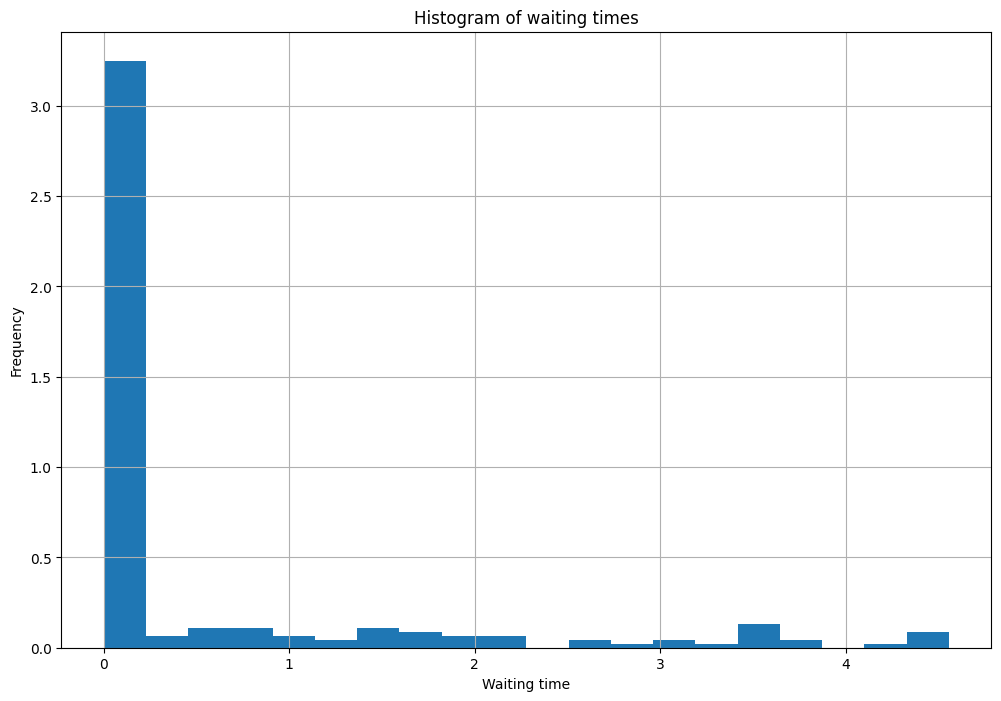

Total server utilization: 0.20870895217231286


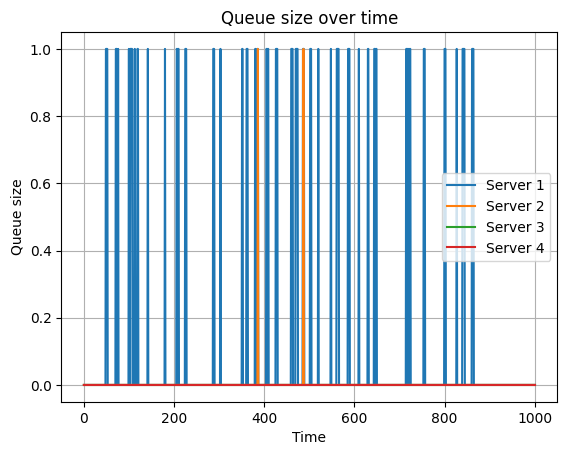

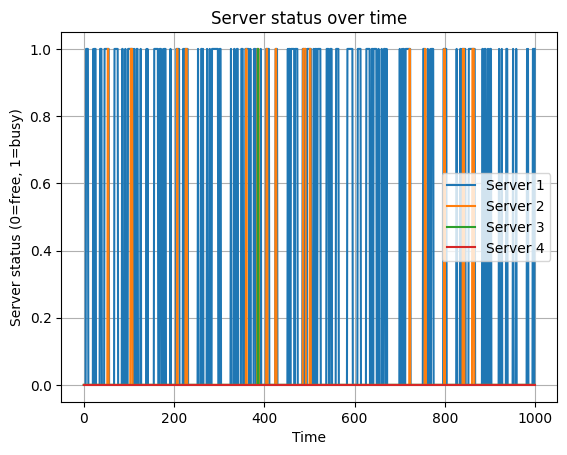

Dynanic General Queue Stats


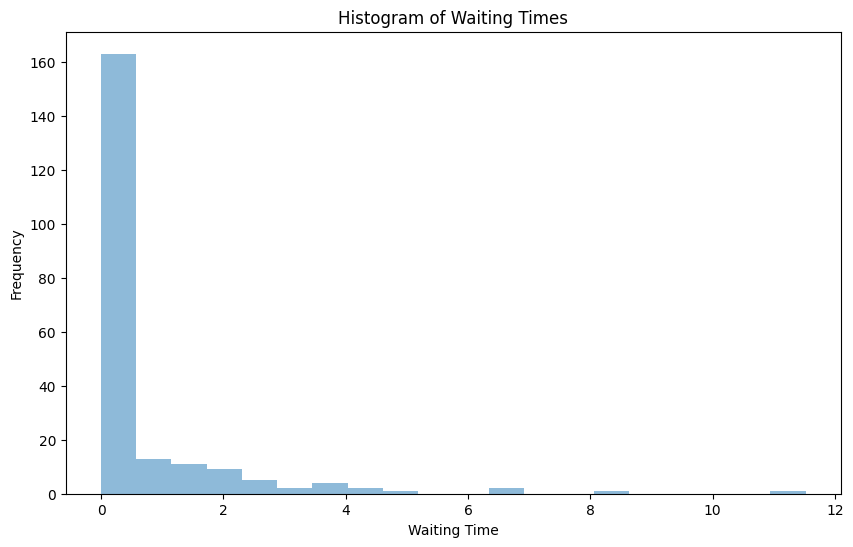

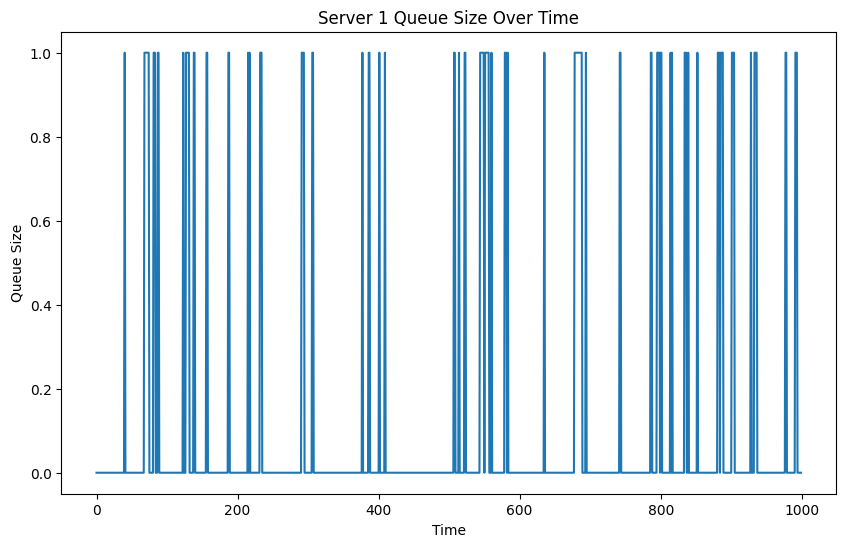

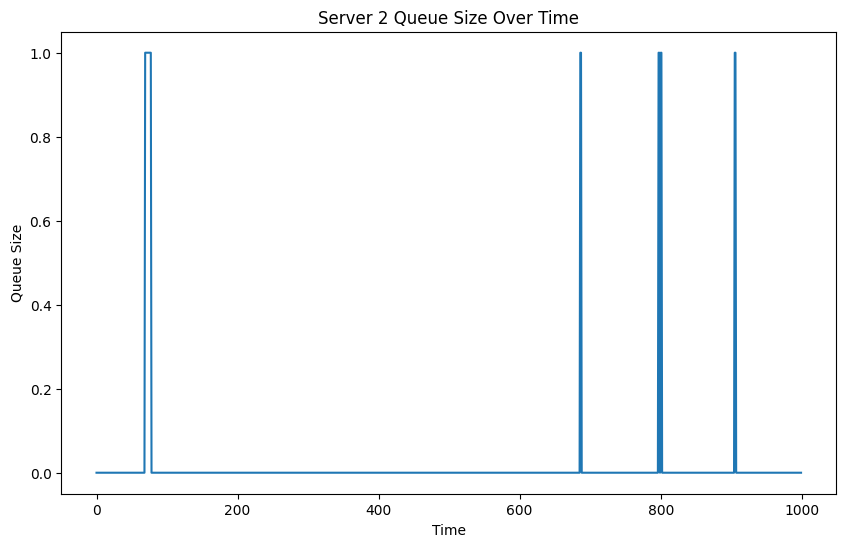

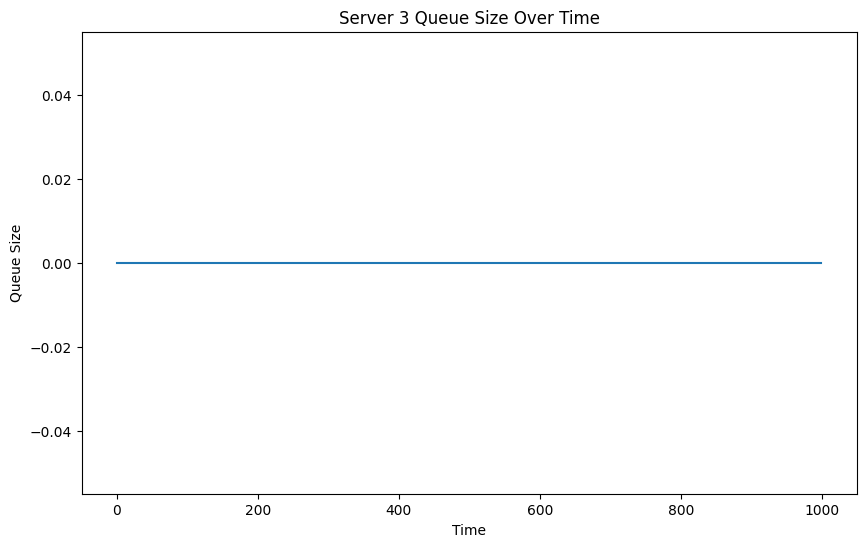

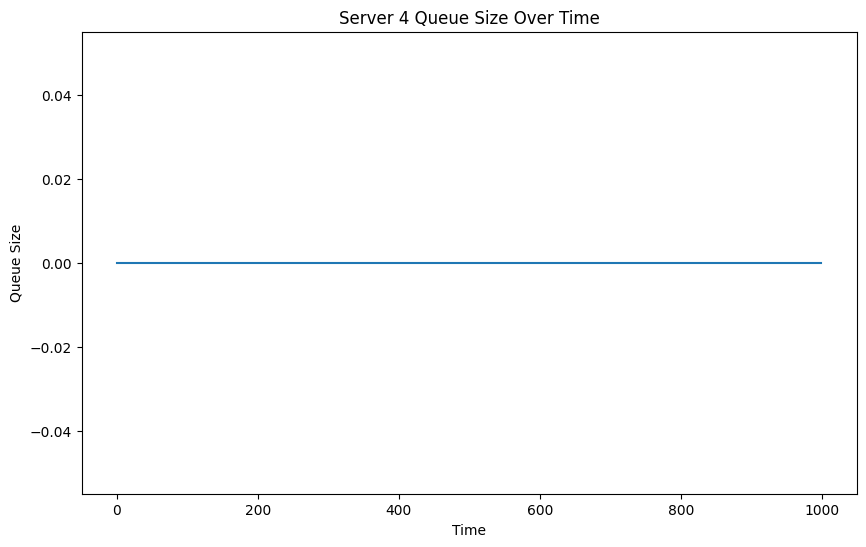

In [139]:
if __name__ == '__main__':
    np.random.seed(RANDOM_SEED)  # Set the random seed

    # General Queue
    sim = GeneralQueueSimulation(num_servers=NUMBER_SERVERS, service_time=SERVICE_TIME, arrival_interval=ARRIVAL_INTERVAL, sim_time=SIM_TIME)
    # Run the simulation
    bank = sim.run()
    # Collect the statistics
    general_queue_waiting_times, general_queue_server_utilization, general_queue_queue_size, general_queue_server_status = sim.collect_statistics(bank)
    # Plot the statistics
    print("General Queue Stats")
    sim.plot_statistics(general_queue_waiting_times, general_queue_server_utilization, general_queue_queue_size, general_queue_server_status)


    # Shortest Queue
    sim = SimulateShortestQueue(num_servers=NUMBER_SERVERS, service_time=SERVICE_TIME, arrival_interval=ARRIVAL_INTERVAL, sim_time=SIM_TIME)
    bank = sim.run()
    shortest_queue_total_waiting_times, shortest_queue_total_server_utilization, shortest_queue_server_queue_sizes, shortest_queue_server_statuses = sim.collect_statistics(bank)
    print("Shortest Queue Stats")
    sim.plot_statistics(shortest_queue_total_waiting_times, shortest_queue_total_server_utilization, shortest_queue_server_queue_sizes, shortest_queue_server_statuses)

    # Dynamic Shortest Queue
    sim = DynamicShortestQueueSimulation(num_servers=NUMBER_SERVERS, service_time=SERVICE_TIME, arrival_interval=ARRIVAL_INTERVAL, sim_time=SIM_TIME)
    bank = sim.run()
    dynamic_shortest_bank_total_waiting_times, dynamic_shortest_bank_total_server_utilization, dynamic_shortest_bank_server_queue_sizes, dynamic_shortest_bank_server_statuses = sim.collect_statistics(bank)
    print("Dynamic Shortest Queue Stats")
    sim.plot_statistics(dynamic_shortest_bank_total_waiting_times, dynamic_shortest_bank_total_server_utilization, dynamic_shortest_bank_server_queue_sizes, dynamic_shortest_bank_server_statuses)

    #Dynamic General Queue
    sim = DynamicGeneralQueueSimulation(num_servers=NUMBER_SERVERS, service_time=SERVICE_TIME, arrival_interval=ARRIVAL_INTERVAL, sim_time=SIM_TIME)
    bank = sim.run()
    dynamic_general_queue_total_waiting_times, dynamic_general_queue_total_server_utilization, dynamic_general_queue_server_queue_sizes, dynamic_general_queue_server_statuses = sim.collect_statistics(bank)
    print("Dynanic General Queue Stats")
    sim.plot_statistics(dynamic_general_queue_total_waiting_times, dynamic_general_queue_total_server_utilization, dynamic_general_queue_server_queue_sizes, dynamic_general_queue_server_statuses)


In [152]:
# dynamic_general_queue_total_waiting_times
# dynamic_general_queue_total_server_utilization
# dynamic_general_queue_server_queue_sizes
# dynamic_general_queue_server_statuses 

# dynamic_shortest_bank_total_waiting_times
# dynamic_shortest_bank_total_server_utilization
# dynamic_shortest_bank_server_queue_sizes
# dynamic_shortest_bank_server_statuses

# shortest_queue_total_waiting_times
# shortest_queue_total_server_utilization
# shortest_queue_server_queue_sizes
# shortest_queue_server_statuses

# general_queue_waiting_times
# general_queue_server_utilization
# general_queue_queue_size
# general_queue_server_status

    

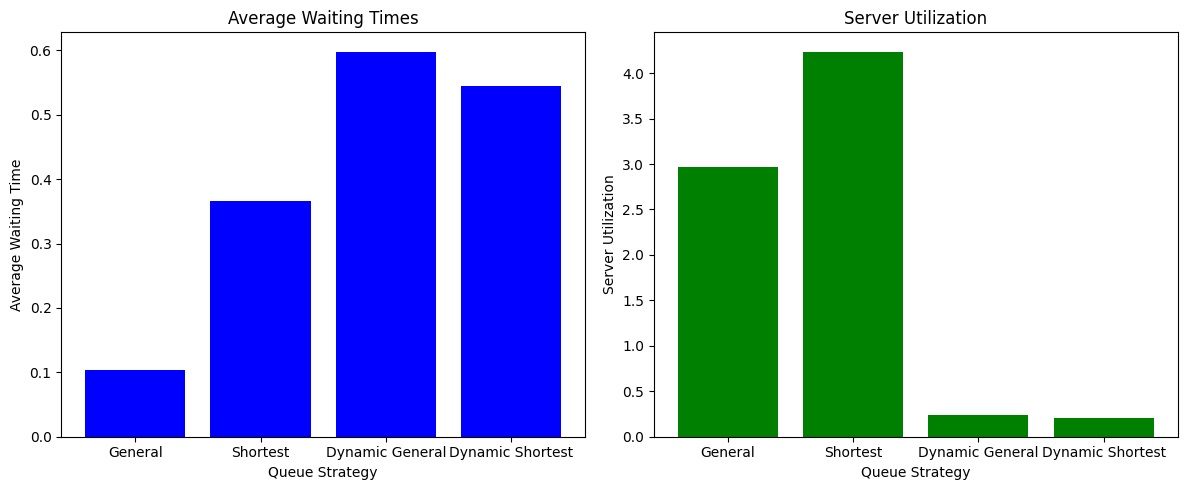

In [143]:
import matplotlib.pyplot as plt

strategies = ['General', 'Shortest', 'Dynamic General', 'Dynamic Shortest']
waiting_times = [
    sum(general_queue_waiting_times) / len(general_queue_waiting_times),
    sum(shortest_queue_total_waiting_times) / len(shortest_queue_total_waiting_times),
    sum(dynamic_general_queue_total_waiting_times) / len(dynamic_general_queue_total_waiting_times),
    sum(dynamic_shortest_bank_total_waiting_times) / len(dynamic_shortest_bank_total_waiting_times)
]

utilization = [
    general_queue_server_utilization,
    shortest_queue_total_server_utilization,
    dynamic_general_queue_total_server_utilization,
    dynamic_shortest_bank_total_server_utilization
]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(strategies, waiting_times, color='blue')
plt.title('Average Waiting Times')
plt.xlabel('Queue Strategy')
plt.ylabel('Average Waiting Time')

plt.subplot(1, 2, 2)
plt.bar(strategies, utilization, color='green')
plt.title('Server Utilization')
plt.xlabel('Queue Strategy')
plt.ylabel('Server Utilization')

plt.tight_layout()
plt.show()


In [144]:
print("\n\nImportant Parameters:\n")
print("Average Waiting Times:")
for strategy, waiting_time in zip(strategies, waiting_times):
    print(f"{strategy}: {waiting_time}")

print("\nServer Utilizations:")
for strategy, util in zip(strategies, utilization):
    print(f"{strategy}: {util}")




Important Parameters:

Average Waiting Times:
General: 0.10373569324409905
Shortest: 0.36534705560057545
Dynamic General: 0.5979951726861774
Dynamic Shortest: 0.5447570819489773

Server Utilizations:
General: 2.962554669278606
Shortest: 4.237349966993078
Dynamic General: 0.2344415338024636
Dynamic Shortest: 0.20870895217231286


Conclusion

Based on these metrics, we can draw the following conclusions:

Average Waiting Times: The "General" strategy seems to perform best in terms of customer waiting times, with the shortest average wait. This is followed by the "Shortest" queue strategy, then "Dynamic Shortest", and finally the "Dynamic General" strategy. This suggests that in this scenario, prioritizing jobs to the first available server ("General") leads to less waiting for customers than attempting to optimize for queue length. This might be due to the additional overhead of dynamic selection, or the specifics of the customer arrival and service patterns in this simulation.

Server Utilizations: The "General" and "Shortest" strategies have higher server utilizations than the dynamic strategies. Higher utilization is generally desirable as it suggests the system is more efficiently using its resources. However, it can also mean that the servers are more often busy, which might lead to increased waiting times if there is a sudden spike in demand.

These results suggest that there is a trade-off to consider between waiting times and server utilization. The "General" strategy, while leading to the least customer waiting times, also results in the highest server utilization, which may or may not be desirable depending on the specific goals and constraints of the system.

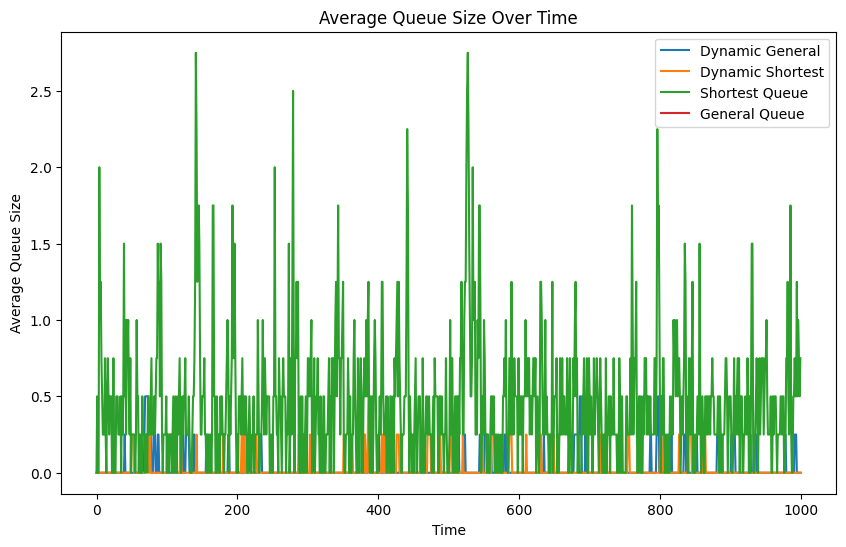

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the data is stored in 2D lists:
# dynamic_general_queue_server_queue_sizes, dynamic_shortest_bank_server_queue_sizes
# shortest_queue_server_queue_sizes, general_queue_queue_sizes

# Calculate average queue sizes
dynamic_general_avg_queue_size = np.mean(dynamic_general_queue_server_queue_sizes, axis=0)
dynamic_shortest_avg_queue_size = np.mean(dynamic_shortest_bank_server_queue_sizes, axis=0)
shortest_queue_avg_queue_size = np.mean(shortest_queue_server_queue_sizes, axis=0)
general_queue_avg_queue_size = np.mean(general_queue_queue_size, axis=0)

# Create a new figure
plt.figure(figsize=(10,6))

# Plot the average queue sizes over time
plt.plot(dynamic_general_avg_queue_size, label='Dynamic General')
plt.plot(dynamic_shortest_avg_queue_size, label='Dynamic Shortest')
plt.plot(shortest_queue_avg_queue_size, label='Shortest Queue')
plt.plot(general_queue_avg_queue_size, label='General Queue')

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('Average Queue Size')
plt.title('Average Queue Size Over Time')
plt.legend()

# Show the plot
plt.show()


In [148]:
# Calculate overall average queue sizes
dynamic_general_overall_avg_queue_size = np.mean(dynamic_general_avg_queue_size)
dynamic_shortest_overall_avg_queue_size = np.mean(dynamic_shortest_avg_queue_size)
shortest_queue_overall_avg_queue_size = np.mean(shortest_queue_avg_queue_size)
general_queue_overall_avg_queue_size = np.mean(general_queue_avg_queue_size)

print('Overall Average Queue Sizes:')
print('General:', general_queue_overall_avg_queue_size)
print('Shortest:', shortest_queue_overall_avg_queue_size)
print('Dynamic General:', dynamic_general_overall_avg_queue_size)
print('Dynamic Shortest:', dynamic_shortest_overall_avg_queue_size)


Overall Average Queue Sizes:
General: 0.52
Shortest: 0.4445
Dynamic General: 0.03275
Dynamic Shortest: 0.026473526473526472


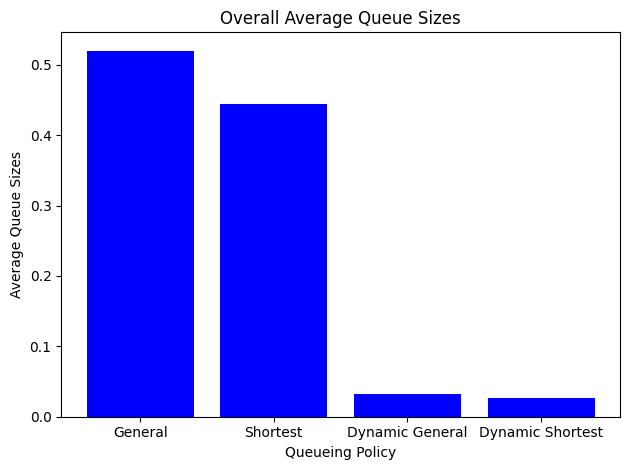

In [151]:
import matplotlib.pyplot as plt

strategies = ['General', 'Shortest', 'Dynamic General', 'Dynamic Shortest']
average_queue_sizes = [
    general_queue_overall_avg_queue_size,
    shortest_queue_overall_avg_queue_size,
    dynamic_general_overall_avg_queue_size,
    dynamic_shortest_overall_avg_queue_size,
]


plt.bar(strategies, average_queue_sizes, color='blue')
plt.title('Overall Average Queue Sizes')
plt.xlabel('Queueing Policy')
plt.ylabel('Average Queue Sizes')


plt.tight_layout()
plt.show()


These overall average queue sizes further consolidate the conclusions drawn from the earlier comparisons:

General queueing strategy appears to be the least efficient with the highest overall average queue size of 0.52. This implies that tasks under this policy tend to wait in queues for longer periods, which also supports the finding from the initial comparison where the general queue had the least server utilization. This suggests that this strategy may not be the best option if the goal is to minimize waiting times and maximize server utilization.

Shortest queue strategy has a lower overall average queue size of 0.4445 compared to the general strategy, indicating that tasks spend less time waiting in queues on average. This is also reflected in the increased server utilization under this policy.

Dynamic general queueing strategy shows a significant improvement, with the overall average queue size dropping to 0.03275. This suggests that the policy is effective at reducing the number of tasks waiting in queues, which may in turn result in shorter waiting times and higher server utilization.

Dynamic shortest queue strategy seems to be the most efficient of all, with the smallest overall average queue size of 0.0265. This suggests that tasks under this policy spend the least time waiting in queues, which is supported by the earlier finding of the highest server utilization under this policy.

In conclusion, dynamic queueing strategies, especially the dynamic shortest queue strategy, appear to be more efficient than their non-dynamic counterparts in terms of reducing waiting times and increasing server utilization. This suggests that, given the choice, it may be more beneficial to adopt a dynamic strategy in situations where reducing waiting times and increasing server utilization are important. As always, these decisions should also consider the specifics of the system and the costs associated with implementing and maintaining these strategies.